Introduction: 

Good Seed, a supermarket chain that sells alcohol, aims to use machine learning to automatically scan customers' faces and predict their age to adhere to alcohol laws. We were tasked with investigating this project. Using photographs of faces and real ages, we'll build, train, and test a convolutional neural network to create a reliable model. We'll start by loading and analyzing the data, including age distribution and examining sample images. Then, we'll build and train a ResNet model using Keras and test it on a GPU. Finally, we'll evaluate the model's effectiveness.

## Initialization

In [1]:
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\IU STUDENT\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\IU STUDENT\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\IU STUDENT\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\IU STUDENT\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\IU STUDENT\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\IU STUDENT\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
#Import labels to DataFrame.
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except FileNotFoundError:
    labels = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/faces/labels.csv')

#Examine shape of labels DataFrame.
print(f'The "labels" DataFrame has the following shape: {labels.shape}')

HTTPError: HTTP Error 403: Forbidden

In [3]:
#Create data generator to examine images.
exploratory_datagen = ImageDataGenerator()
exploratory_directory = exploratory_datagen.flow_from_dataframe(
    directory='/datasets/faces/final_files/',
    dataframe=pd.read_csv('/datasets/faces/labels.csv'),
    target_size=(250, 250),
    batch_size=16,
    class_mode='raw',
    x_col='file_name',
    y_col='real_age',
    seed=12345)

Found 7591 validated image filenames.


Loaded the training dataset's labels into a Dataframe and created a data generator that reads images from the 'final files' folder in batches of 16. The total number of observations in the 'labels' Dataframe (7591) matches the number of images validated by the data generator.

In [4]:
#Check for null values
print(f'Total NaNs in labels file: {labels.isnull().sum().sum()}')

Total NaNs in labels file: 0


In [5]:
#Print length of labels file
print(f'Total duplicates in labels file: {labels.duplicated().sum()}')

Total duplicates in labels file: 0


In [6]:
print(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


We loaded the data. For the labels in a CSV file, we loaded them into a Dataframe with their corresponding file names. To avoid overloading our RAM, we created a data generator that reads images in batches of 16 and reduces them to 250x250 pixels.

We preprocessed the 'labels' Dataframe by checking for missing values, duplicates, and data type appropriateness. The Dataframe has no missing values, duplicates, or improper data types. In the next section, we'll perform exploratory data analysis.

## EDA

In [7]:
#Examine statistical info for dataset
print(labels['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


The mean age for individuals in our dataset is approximately 31, as shown by the 'real age' column. The age range is 1 to 100, covering all expected ages in a store. The majority of images are for individuals between 20 and 41. Let's visualize these findings with an age distribution plot.

/tmp/ipykernel_50/1394066834.py:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Density', Fontsize=12)


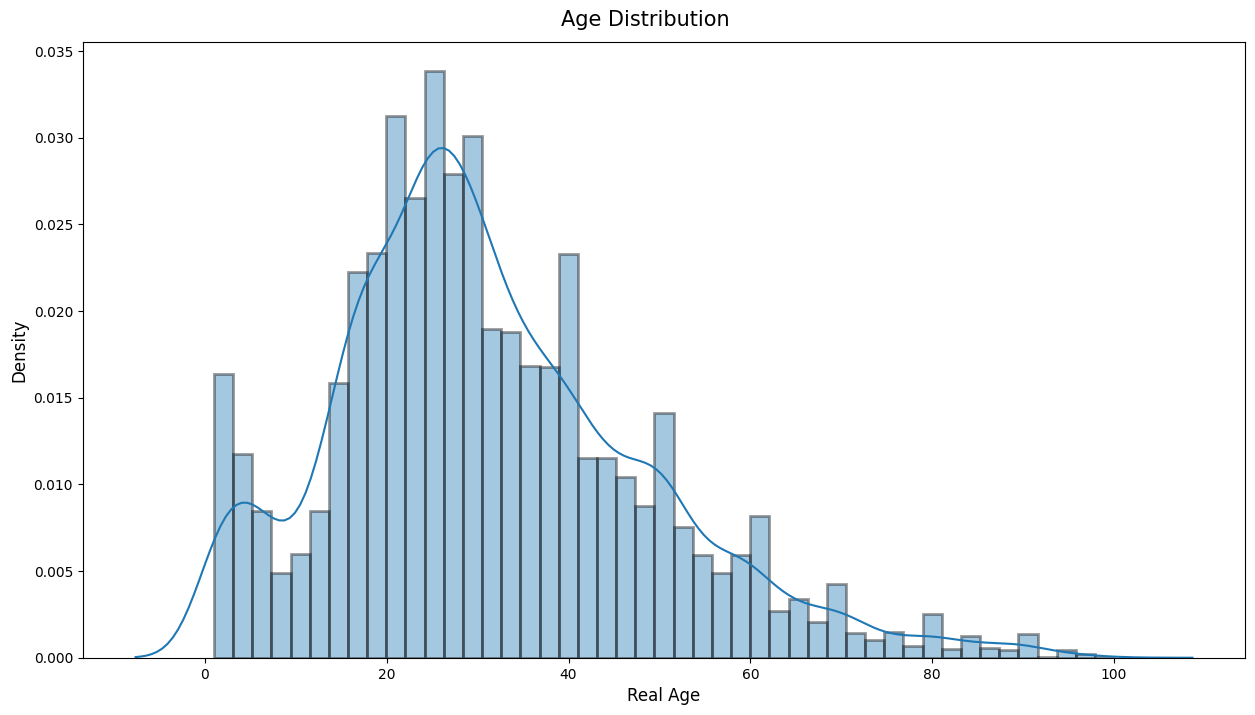

In [8]:
#Create displot to visualize age distribution.
fig = plt.figure(figsize=(15, 8))
plt.suptitle('Age Distribution', fontsize=15, y=.92)
sns.distplot(labels['real_age'], hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel('Real Age', fontsize=12)
plt.ylabel('Density', Fontsize=12)
plt.show()

From the distplot, a combination of a histogram and kernel density estimator, we see that most observations are around age 30. After the mean of 31, the number of individuals per age group decreases smoothly, with the fewest between 95 and 100. Surprisingly, there are many images for ages 1 to 5. To better understand the age distribution, let's categorize ages into four bins: under 21, 21 to 40, 40 to 60, and 60 to 100.

In [9]:
#Create function to categorizing individuals by age group.
def categorize(x):
    if x <= 20:
        return '0-20'
    elif 40 >= x > 20:
        return '21-40'
    elif 60 >= x > 40:
        return '40-60'
    else:
        return '60-100'
    
#Categorize individuals by age group.
category = labels.copy()
category['group'] = category['real_age'].apply(categorize)

#Obtain percentage for each age group.
grouped_category = category.groupby('group')['real_age'].count().to_frame(name='total_grouped').reset_index()
grouped_category['percentage'] = ((grouped_category['total_grouped'] / 
                                   grouped_category['total_grouped'].sum()) * 100).round(2)

#Display percentages for age groups.
display(grouped_category.set_index('group'))

,total_grouped,percentage
group,,
0-20,2054,27.06
21-40,3628,47.79
40-60,1463,19.27
60-100,446,5.88


From the Dataframe, we can see that most observations are for individuals between 21 and 40. The second largest age group is 0 to 21. While young children won't visit store alone, having many samples for under 21 is important for our model to prevent underage alcohol purchases. It may not seem neccessary to train on young children's images, but it's crucial to distinguish between very young children and those who may appear young but are nearly 21. Finally, about 20% of the dataset is between 40 and 60, and less than 6% is between 60 and 100. While we have fewer images of the latter, this shouldn't concern us as we believe they'll be reliably identified as over 21.

In [10]:
#Select features and target from our image generator directory.
features, target = next(exploratory_directory)

### Findings

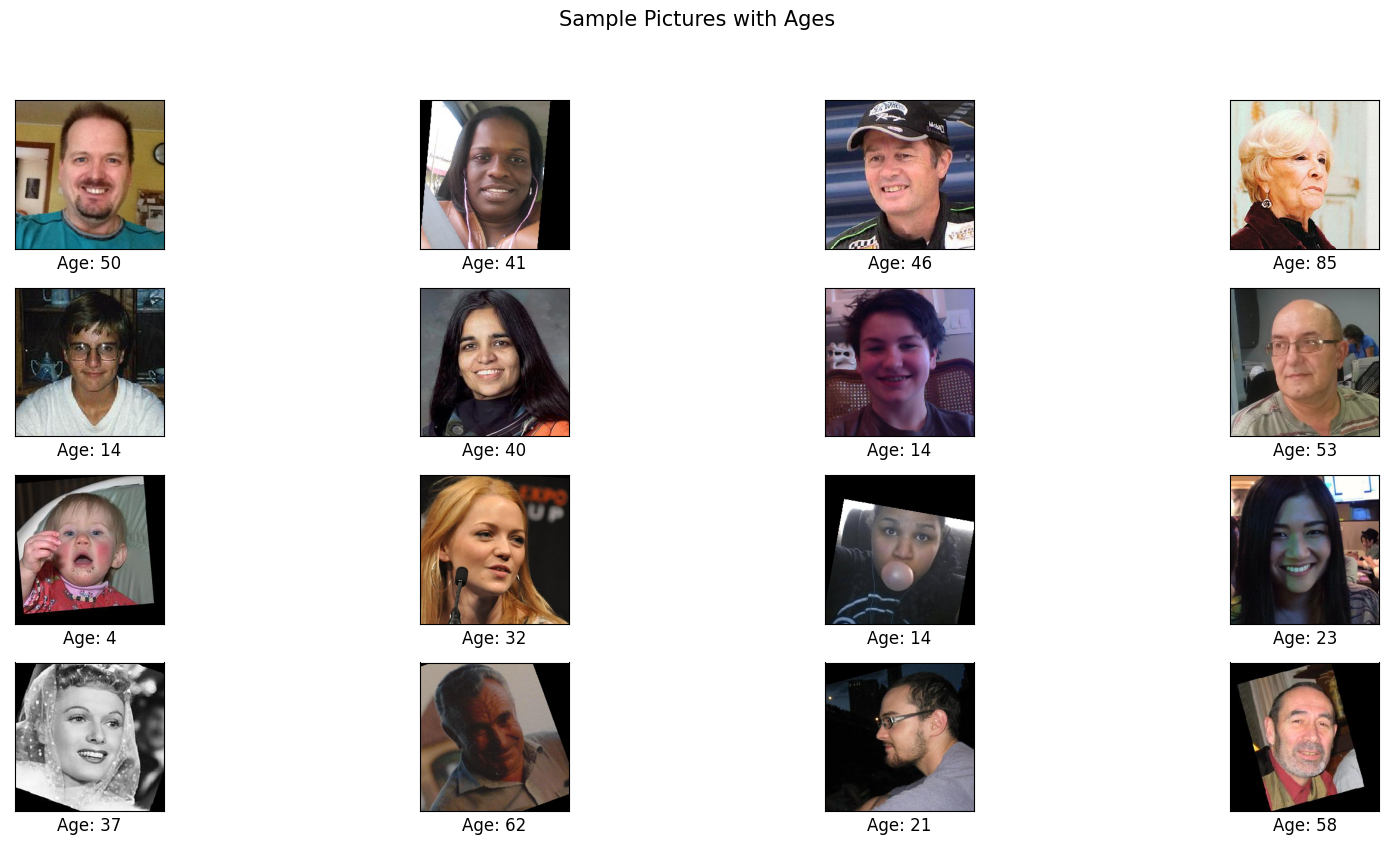

In [11]:
#Create figure to plot images.
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Sample Pictures with Ages", fontsize=15, y=1.05)

#Loop through images and print each with their relevant age.
for image in range(16):
    array = np.array(features[image])
    array = array/255
    axs=fig.add_subplot(4, 4, image+1)
    
    #Add age for each individual.
    axs.set_xlabel(f'Age: {target[image]}', fontsize=12)
    
    #Remove x and y ticks.
    axs.set_xticks([])
    axs.set_yticks([])
    plt.imshow(array)
plt.tight_layout()

The above images represent the first 16 form our image data generator. Each image is printed with its appropriate age, confirming that our generator functions correctly and assigns targets to their relevant photos.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [12]:
#Function to load training data.
def load_train(path):
    """
    This function loads the training part of the dataset from the specified path.
    """
    datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=.25)
    
    #Use flow from dataframe to import images and appropriate labels.
    train_gen_flow = datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=pd.read_csv(path + 'labels.csv'),
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        x_col='file_name',
        y_col='real_age',
        seed=12345)

    return train_gen_flow

In [13]:
#Function to load testing data.
def load_test(path): 
    """
    This function loads the testing part of the dataset from the specified path.
    """
    datagen = ImageDataGenerator(rescale=1./255, validation_split=.25)
    
    #Use flow from dataframe to import images and appropriate labels.
    test_gen_flow = datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=pd.read_csv(path + 'labels.csv'),
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        x_col='file_name',
        y_col='real_age',
        seed=12345)

    return test_gen_flow

In [14]:
#Function to create model.
def create_model(input_shape):
    """
    This function defines and compiles our model.
    """
    #Define ResNet50 as backbone. Remove top layers.
    backbone = ResNet50(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

    #Define model.
    model = Sequential([
    backbone,
    GlobalAveragePooling2D(),
    Dense(12, activation='relu'),
    Dense(1, activation='relu')])

    #Compile model.
    model.compile(
        optimizer=Adam(lr=.001),
        loss='mae',
        metrics=['mae'])

    return model

In [15]:
#function to train model
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
    validation_data=test_data,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2)

    return model

We created several functions for building and training our convolutional neural network. The first two load the training and testing datasets. We used an image data generator to load images in batches of 16 with specified augmentations and reduced pixel sizes to 150x150.

The function that creates and compiles our model follows the ResNet50 architecture, except for our added layers. We used the Adam optimizer with a learning rate of .001 and MAE for both the loss function and evaluation metric.

Finally, we trained the model on the training dataset and validated it with the test data. We set the number of epochs to 20, though we would prefer more for better results, but chose 20 for time and resource conservation.

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [16]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20

2021-08-19 12:37:30.859848: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2021-08-19 12:37:31.174847: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 45s - loss: 260.2839 - mae: 11.8298 - val_loss: 490.6014 - val_mae: 17.0055

Epoch 2/20

356/356 - 36s - loss: 118.8604 - mae: 8.2253 - val_loss: 188.2047 - val_mae: 10.3036

Epoch 3/20

356/356 - 35s - loss: 93.7831 - mae: 7.4002 - val_loss: 192.1293 - val_mae: 10.9365

Epoch 4/20

356/356 - 35s - loss: 74.7336 - mae: 6.6016 - val_loss: 99.8093 - val_mae: 7.4662

Epoch 5/20

356/356 - 35s - loss: 61.2775 - mae: 5.9969 - val_loss: 126.7901 - val_mae: 8.2667

Epoch 6/20

356/356 - 35s - loss: 54.6650 - mae: 5.6253 - val_loss: 111.8150 - val_mae: 8.0362

Epoch 7/20

356/356 - 35s - loss: 46.7774 - mae: 5.2492 - val_loss: 88.9159 - val_mae: 7.3049

Epoch 8/20

356/356 - 36s - loss: 41.4468 - mae: 4.8811 - val_loss: 99.6786 - val_mae: 7.3732

Epoch 9/20

356/356 - 35s - loss: 36.0747 - mae: 4.5857 - val_loss: 87.1122 - val_mae: 6.9876

Epoch 10/20

356/356 - 35s - loss: 30.7393 - mae: 4.2403 - val_loss: 78.8586 - val_mae: 6.7305

Epoch 11/20

356/356 - 35s - loss: 27.6634 - mae: 4.0253 - val_loss: 79.2080 - val_mae: 6.5764

Epoch 12/20

356/356 - 36s - loss: 26.2344 - mae: 3.8508 - val_loss: 90.1072 - val_mae: 7.0437

Epoch 13/20

356/356 - 36s - loss: 23.6925 - mae: 3.7371 - val_loss: 81.8165 - val_mae: 6.8021

Epoch 14/20

356/356 - 36s - loss: 21.3308 - mae: 3.4904 - val_loss: 84.9309 - val_mae: 6.7948

Epoch 15/20

356/356 - 35s - loss: 19.5359 - mae: 3.4179 - val_loss: 135.9364 - val_mae: 8.9805

Epoch 16/20

356/356 - 35s - loss: 17.7645 - mae: 3.2027 - val_loss: 110.5504 - val_mae: 8.2450

Epoch 17/20

356/356 - 35s - loss: 16.8798 - mae: 3.1300 - val_loss: 78.4753 - val_mae: 6.5252

Epoch 18/20

356/356 - 35s - loss: 17.3177 - mae: 3.1430 - val_loss: 80.6793 - val_mae: 6.7540

Epoch 19/20

356/356 - 35s - loss: 17.1261 - mae: 3.1208 - val_loss: 106.0266 - val_mae: 7.4396

Epoch 20/20

356/356 - 36s - loss: 16.3323 - mae: 3.0980 - val_loss: 74.2701 - val_mae: 6.3732

WARNING:tensorflow:sample_weight modes were coerced from

...

to  
['...']

119/119 - 9s - loss: 76.0105 - mae: 6.4858

Test MAE: 6.4858

Our model exceeded the maximum allowable threshold. Good Seed requires a mean absolute error of less than 8 for the test set, meaning the average predicted age difference from actual age is no more than 8 years.

After 20 epochs, our model MAE for the test set is about 6.5, which is 1.5 years below the limit. Good Seed should be satisfied with the current model, though improvements are possible.

## Conclusions

Developed a model for Good Seed to determine an individual's age from an image with a maximum error of 8. Performed exploratory data analysis to visualize the age distribution in the dataset. The mean age is approximately 31, and most individuals are between 18 and 40.

Created functions to define, develop, and train a ResNet50 model with custom top layers. Set the numbers of epochs to 20 and use Adam as the optimizer with a learning rate of .0001. Evaluated the model's performance on the testing dataset. The mean absolute error is approximately 6.5, which meets Good Seed's requirements.

While our model meets Good Seed's requirements, we suggest a classification model instead of a regression one. The goal is to ensure no one under the legal drinking age can buy alcohol. Our model's MAE is below the threshold, but it may not identify all underage or of appropriate age. Developers should ensure a higher proportion of images for 'borderline' ages (1-2 years below and above the legal drinking age) in training. If the model can differentiate between individuals specifically below and above the legal drinking age, it would be more useful to Good Seed.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training